<a href="https://colab.research.google.com/github/anniewit/IANNWTF-2020/blob/main/FlippedClassroom03_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
# NEXT LINE ONLY FOR COLAB!
# %tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
# COMMENT OUT THIS LINE FOR COLAB!
#%matplotlib notebook

In [28]:
print(tf.__version__)

2.3.0


**Disclaimer:** This Notebook heavily depends on the work of Luke Effenberger who held the course last year. You can find his original material under:
https://lukeeffenberger.github.io/IANNWTF-2019/

# Flipped Classroom Session 12.11.20
#### Here are the solutions of the notebook we worked on during the session. The notebook can be found here: https://colab.research.google.com/github/anniewit/IANNWTF-2020/blob/main/Simple_MLP_Practise.ipynb 

#### We recommend first working through the notebook and then coming back here to check the solutions.

### Create a simple regression dataset

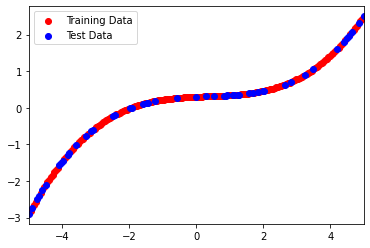

In [29]:
xs = np.linspace(-5,5, 200, dtype=np.float32)
def f(x):
    return 0.02*(x**3-x**2+2*x)+0.3
ys = np.array([f(x) for x in xs], dtype=np.float32)

training_data_ids = np.random.choice(200,150, replace=False)
test_data_ids = np.array([i if i not in training_data_ids else 999 for i in range(200)])
test_data_ids = test_data_ids[test_data_ids < 201]
training_data_xs = xs[training_data_ids]
training_data_ys = ys[training_data_ids]
test_data_xs = xs[test_data_ids]
test_data_ys = ys[test_data_ids]

plt.scatter(training_data_xs, training_data_ys, c='red')
plt.scatter(test_data_xs, test_data_ys, c='blue')
plt.legend(("Training Data","Test Data"))
plt.xlim(-5,5)
plt.show()

In [30]:
# First understand the shape that your data has.
print(training_data_xs.shape)
print(training_data_ys.shape)
print(test_data_xs.shape)
print(test_data_ys.shape)

(150,)
(150,)
(50,)
(50,)


In [31]:
# It is easiest to use this dataset with TensorFlow by converting
# it to a tf.data.Dataset (https://www.tensorflow.org/api_docs/python/tf/data/Dataset).
# If, as in our case, you want to convert Numpy Arrays into a dataset
# use tf.data.Dataset.from_tensor_sclices

train_dataset_xs = tf.data.Dataset.from_tensor_slices(training_data_xs)
train_dataset_xs = train_dataset_xs.map(lambda x: tf.reshape(x, (-1,)))
train_dataset_ys = tf.data.Dataset.from_tensor_slices(training_data_ys)

train_dataset = tf.data.Dataset.zip((train_dataset_xs, train_dataset_ys))
train_dataset = train_dataset.batch(20)
train_dataset = train_dataset.shuffle(buffer_size=128)



test_dataset_xs = tf.data.Dataset.from_tensor_slices(test_data_xs)
test_dataset_xs = test_dataset_xs.map(lambda x: tf.reshape(x, (-1,1)))
test_dataset_ys = tf.data.Dataset.from_tensor_slices(test_data_ys)


test_dataset = tf.data.Dataset.zip((test_dataset_xs, test_dataset_ys))


In [32]:
for (x,y) in train_dataset:
    print(x.shape)

(20, 1)
(20, 1)
(20, 1)
(10, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)


### Build a simple network.

In [33]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the hidden layer
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.relu
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.relu
                                               )                              
        self.output_layer = tf.keras.layers.Dense(units=1, use_bias=False)
                                               
       
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

### Define Training and Testing Steps.

In [34]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data

    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        test_loss_aggregator.append(sample_test_loss.numpy())

    test_loss = np.mean(test_loss_aggregator)

    return test_loss
  



### Training Loop

In [35]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 250
learning_rate = 0.01
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
mse = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []

#testing once before we begin
test_loss = test(model, test_dataset, mse)
test_losses.append(test_loss)


#check how model performs on train data once before we begin
train_loss = test(model, train_dataset, mse)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, mse, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss = test(model, test_dataset, mse)
    test_losses.append(test_loss)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25
Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29
Epoch: __ 30
Epoch: __ 31
Epoch: __ 32
Epoch: __ 33
Epoch: __ 34
Epoch: __ 35
Epoch: __ 36
Epoch: __ 37
Epoch: __ 38
Epoch: __ 39
Epoch: __ 40
Epoch: __ 41
Epoch: __ 42
Epoch: __ 43
Epoch: __ 44
Epoch: __ 45
Epoch: __ 46
Epoch: __ 47
Epoch: __ 48
Epoch: __ 49
Epoch: __ 50
Epoch: __ 51
Epoch: __ 52
Epoch: __ 53
Epoch: __ 54
Epoch: __ 55
Epoch: __ 56
Epoch: __ 57
Epoch: __ 58
Epoch: __ 59
Epoch: __ 60
Epoch: __ 61
Epoch: __ 62
Epoch: __ 63
Epoch: __ 64
Epoch: __ 65
Epoch: __ 66
Epoch: __ 67
Epoch: __ 68
Epoch: __ 69
Epoch: __ 70
Epoch: __ 71
Epoch: __ 72
Epoch: __ 73
Epoch: __ 74
Epoch: __ 75
Epoch: __ 76
Epoch: __

In [36]:
print(train_losses)

[0.99302787, <tf.Tensor: shape=(), dtype=float32, numpy=0.17079999>, <tf.Tensor: shape=(), dtype=float32, numpy=0.069715455>, <tf.Tensor: shape=(), dtype=float32, numpy=0.060603417>, <tf.Tensor: shape=(), dtype=float32, numpy=0.05870924>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0557013>, <tf.Tensor: shape=(), dtype=float32, numpy=0.054478213>, <tf.Tensor: shape=(), dtype=float32, numpy=0.05338975>, <tf.Tensor: shape=(), dtype=float32, numpy=0.052517176>, <tf.Tensor: shape=(), dtype=float32, numpy=0.050142568>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04923265>, <tf.Tensor: shape=(), dtype=float32, numpy=0.047729474>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04610573>, <tf.Tensor: shape=(), dtype=float32, numpy=0.044211775>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04403522>, <tf.Tensor: shape=(), dtype=float32, numpy=0.042555947>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04152382>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04031186>, <tf.Tensor: shape=(), dtype=

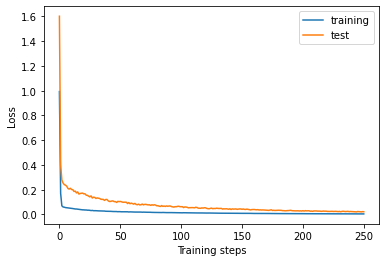

In [37]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()


(200, 1)


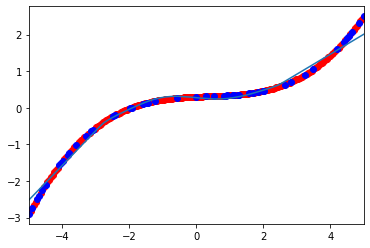

In [38]:
# Plot training and test data.
plt.figure()
plt.scatter(training_data_xs, training_data_ys, c='red')
plt.scatter(test_data_xs, test_data_ys, c='blue')

# Calculate the network's output for 100 xs.
xs =  np.linspace(-5,5,200, dtype=np.float32)
xs = np.reshape(xs, newshape=(-1,1))
print(xs.shape)
ys = model(xs)
#print(ys)

# Plot it.
plt.plot(xs,ys)
plt.xlim(-5,5)
plt.show()